# Set up to use `gplite` in Jupyter Notebooks

Set up the magic commands for R.

In [1]:
%load_ext rpy2.ipython

Improve image quality of `matplotlib` output.

In [2]:
%config InlineBackend.figure_format='retina'

Load the required R libraries.

In [3]:
%%R
library(gplite)
library(ggplot2)

This is gplite version 0.13.0


## Previous `gplite` example

Generate the required data.

In [4]:
%%R -o x -o y
x <- seq(from = -2, to = 2, by = 1)
y <- x^2

Initialize, run the model, and plot.

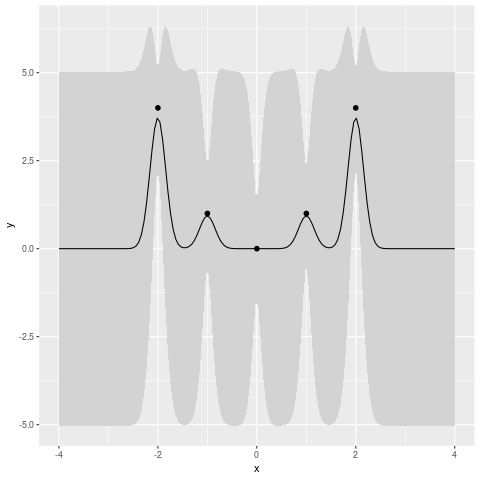

In [5]:
%%R
# Specify the GP model we want to use:
gp_empty <- gp_init(
  
  # A squared exponential (aka Gaussian aka RBF) kernel
  cfs = cf_sexp(
    vars = NULL,
    lscale = 0.3,
    magn = 1,
    prior_lscale = prior_logunif(),
    prior_magn = prior_logunif(),
    normalize = FALSE
  ),  
  
  # Assume Gaussian distributed errors
  lik = lik_gaussian(
    sigma = 0.5, 
    prior_sigma = prior_logunif()
  ), 
  
  # Use the full covariance (i.e., do not approximate)
  method = method_full() 
  
)

# Now fit the model to the data:
gp_optimized <- gp_optim(gp_empty, x, y, verbose = FALSE)

# compute the predictive mean and variance in a grid of points
xt   <- seq(-4, 4, len=150)
pred <- gp_pred(gp_optimized, xt, var = T)

# visualize
mu <- pred$mean
lb <- pred$mean - 2*sqrt(pred$var)
ub <- pred$mean + 2*sqrt(pred$var)

ggplot() + 
  geom_ribbon(aes(x=xt, ymin=lb, ymax=ub), fill='lightgray') +
  geom_line(aes(x=xt, y=mu), linewidth = 0.5) +
  geom_point(aes(x=x, y=y), size=2) +
  xlab('x') + ylab('y')

# GPFlow

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import gpflow
import tensorflow as tf
import tensorflow_probability 

2025-11-20 18:04:18.983215: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-20 18:04:19.020540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 18:04:19.918980: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 18:04:23.956644: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Generate the same data for `gpflow` as for `gplite`.

In [7]:
x = np.arange(start = -2., stop = 3., step = 1.).reshape(5,1)

y = x**2

In [8]:
x

array([[-2.],
       [-1.],
       [ 0.],
       [ 1.],
       [ 2.]])

In [9]:
y

array([[4.],
       [1.],
       [0.],
       [1.],
       [4.]])

Plot the data.

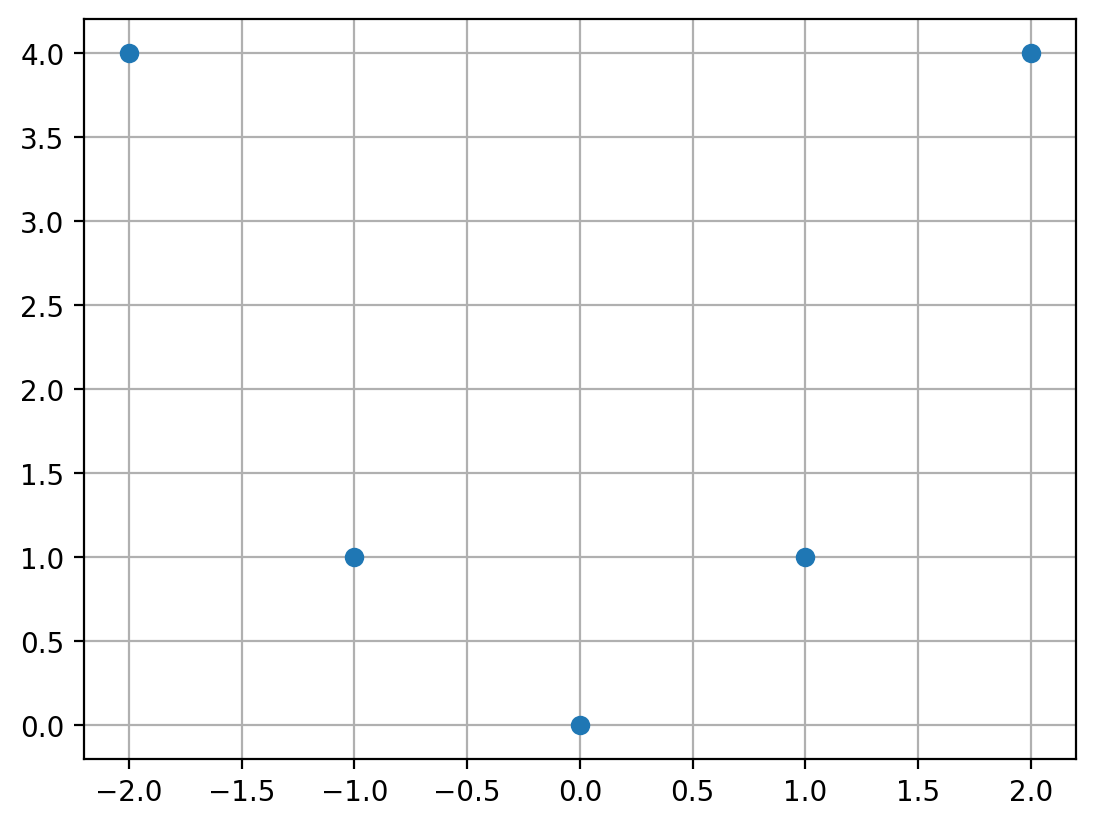

In [10]:
fig, ax = plt.subplots()
ax.scatter(x, y, zorder=2)
ax.grid(True)
plt.show()

## Recapitulate `gp_lite` example

Let us try to recapitulate the above `gp_lite` prediction graph using `gpflow`. The settings for `gp_lite` above were:
* a squared exponential kernel
    * the length scale initial value was 0.3
    * the magnitude (function variance) initial value was 1
    * the prior on the length scale was log uniform
    * the prior on the magnitude was log uniform
* Gaussian distributed error
    * the error initial value was 0.5
    * the prior on the error was log uniform
* Full covariance

TensorFlow Probabilities does not have a log uniform distribution. Therefore, we will need to generate that distribution ourselves.

### No priors

Let us first take the simple case fitting the model without priors.

In [11]:
# starting with a squared exponential distribution
# with variance 1 and length scale 0.3 as above
se_kernel = gpflow.kernels.SquaredExponential(
    variance = 1,
    lengthscales = 0.3
)

# setting the prior on the likelihood
likelihood = gpflow.likelihoods.Gaussian(
    variance = 0.5**2
)

2025-11-19 18:55:14.474050: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
se_kernel

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,1
SquaredExponential.lengthscales,Parameter,Softplus,,True,(),float64,0.3


In [13]:
likelihood

name,class,transform,prior,trainable,shape,dtype,value
Gaussian.variance,Parameter,Softplus + Shift,,True,(),float64,0.25


Fit the model and optimize.

In [14]:
nm_model = gpflow.models.GPR(
    data = (x, y),
    kernel = se_kernel,
    likelihood = likelihood
)

# optimize using Nelder-Mead
opt = gpflow.optimizers.Scipy()
opt.minimize(
    nm_model.training_loss,
    nm_model.trainable_variables,
    method = 'Nelder-Mead'
)

/usr/local/lib/python3.11/dist-packages/gpflow/optimizers/scipy.py:159: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  opt_result = scipy.optimize.minimize(


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 11.886999196552168
             x: [-2.606e+00  1.962e+00  4.697e+00]
           nit: 56
          nfev: 110
 final_simplex: (array([[-2.606e+00,  1.962e+00,  4.697e+00],
                       [-2.606e+00,  1.962e+00,  4.697e+00],
                       [-2.606e+00,  1.962e+00,  4.697e+00],
                       [-2.606e+00,  1.962e+00,  4.697e+00]]), array([ 1.189e+01,  1.189e+01,  1.189e+01,  1.189e+01]))

Make predictions and plot.

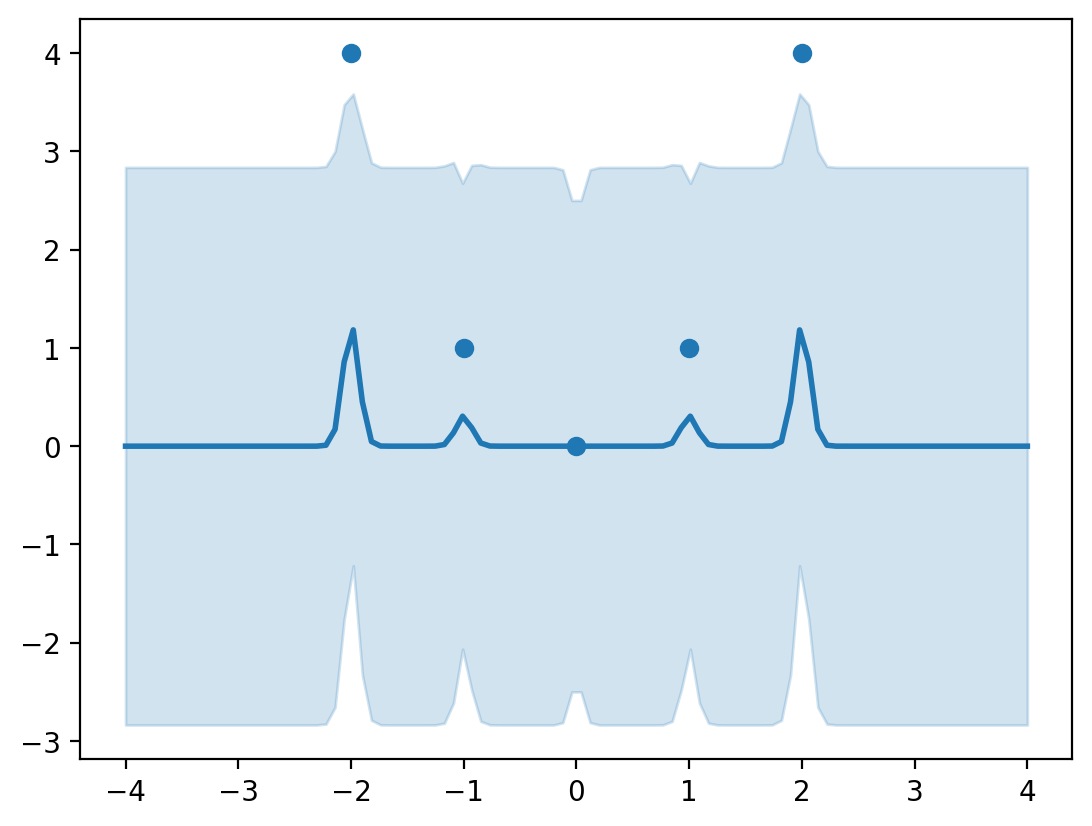

In [15]:
xx = np.linspace(-4, 4, 100).reshape(100,1)
mean, var = nm_model.predict_f(xx)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(xx, mean, lw = 2)
ax.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color = 'C0',
    alpha = 0.2
)

In [16]:
nm_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.09358
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0711982
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4.70647


### Uniform priors

In [17]:
# starting with a squared exponential distribution
# with variance 1 and length scale 0.3 as above
se_kernel = gpflow.kernels.SquaredExponential(
    variance = 1,
    lengthscales = 0.3
)

# setting a uniform prior on both
se_kernel.variance.prior = tensorflow_probability.distributions.Uniform(
    low = gpflow.utilities.to_default_float(0),
    high = gpflow.utilities.to_default_float(1)
)
se_kernel.lengthscales.prior = tensorflow_probability.distributions.Uniform(
    low = gpflow.utilities.to_default_float(0),
    high = gpflow.utilities.to_default_float(1)
)

In [18]:
# setting the prior on the likelihood
likelihood = gpflow.likelihoods.Gaussian(
    variance = 0.5**2
)

# set a prior
likelihood.variance.prior = tensorflow_probability.distributions.Uniform(
    low = gpflow.utilities.to_default_float(0),
    high = gpflow.utilities.to_default_float(1)
)

In [19]:
se_kernel

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,Uniform,True,(),float64,1
SquaredExponential.lengthscales,Parameter,Softplus,Uniform,True,(),float64,0.3


In [20]:
likelihood

name,class,transform,prior,trainable,shape,dtype,value
Gaussian.variance,Parameter,Softplus + Shift,Uniform,True,(),float64,0.25


In [21]:
nm_model = gpflow.models.GPR(
    data = (x, y),
    kernel = se_kernel,
    likelihood = likelihood
)

In [22]:
# optimize using Nelder-Mead
opt = gpflow.optimizers.Scipy()
opt.minimize(
    nm_model.training_loss,
    nm_model.trainable_variables,
    method = 'Nelder-Mead'
)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 14.240526583011755
             x: [ 4.649e-01  5.205e-01  5.413e-01]
           nit: 135
          nfev: 261
 final_simplex: (array([[ 4.649e-01,  5.205e-01,  5.413e-01],
                       [ 4.649e-01,  5.205e-01,  5.413e-01],
                       [ 4.650e-01,  5.205e-01,  5.413e-01],
                       [ 4.650e-01,  5.205e-01,  5.413e-01]]), array([ 1.424e+01,  1.424e+01,  1.424e+01,  1.424e+01]))

Make predictions using the model

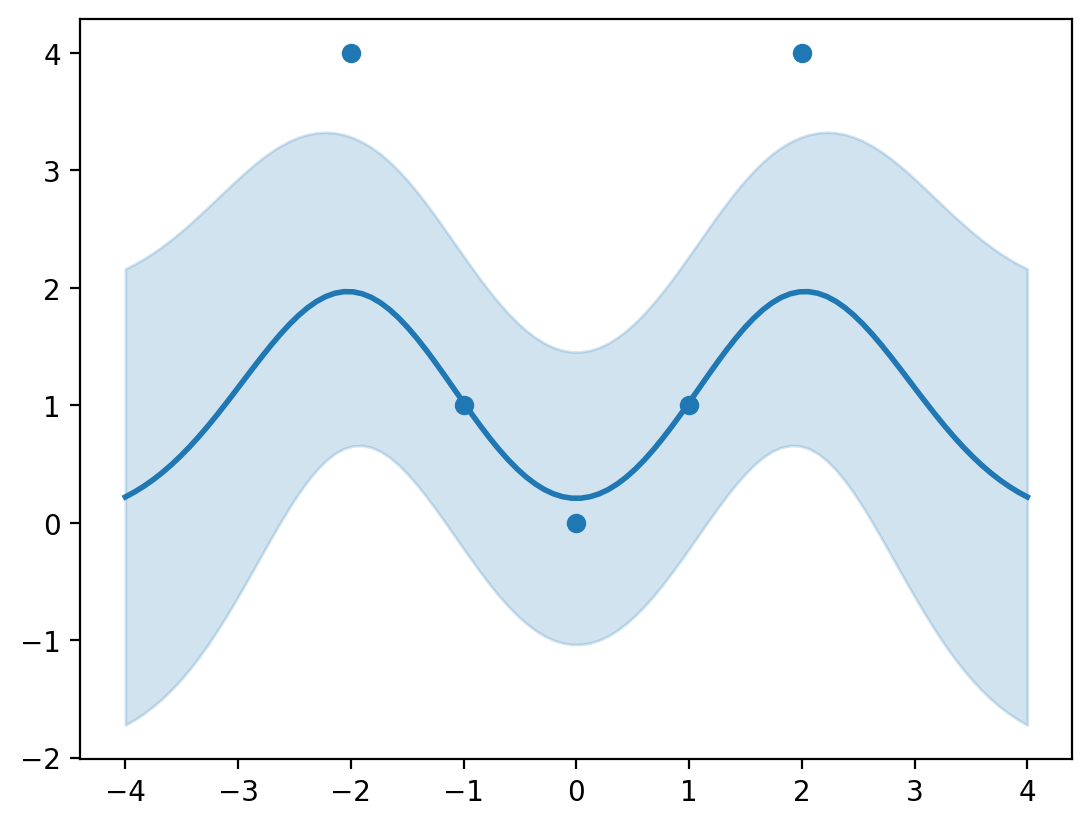

In [23]:
xx = np.linspace(-4, 4, 100).reshape(100,1)
mean, var = nm_model.predict_f(xx)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(xx, mean, lw = 2)
ax.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color = 'C0',
    alpha = 0.2
)

In [24]:
nm_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,Uniform,True,(),float64,0.986908
GPR.kernel.lengthscales,Parameter,Softplus,Uniform,True,(),float64,0.952381
GPR.likelihood.variance,Parameter,Softplus + Shift,Uniform,True,(),float64,0.999999


The uniform distribution restricts the hyperparameters to $(0,1)$, which reduces---most notably---the length-scale parameter making the above graph less "wiggly".

### Log uniform priors

Create a log uniform distribution.

In [25]:
log_uniform = tensorflow_probability.distributions.TransformedDistribution(
    distribution = tensorflow_probability.distributions.Uniform(low = np.log(0.1), high = np.log(1)),
    bijector = tensorflow_probability.bijectors.Exp()
)

(array([2790., 1686., 1259.,  942.,  780.,  634.,  533.,  524.,  448.,
         404.]),
 array([0.10004047, 0.18998844, 0.27993641, 0.36988437, 0.45983234,
        0.54978031, 0.63972827, 0.72967624, 0.81962421, 0.90957217,
        0.99952014]),
 <BarContainer object of 10 artists>)

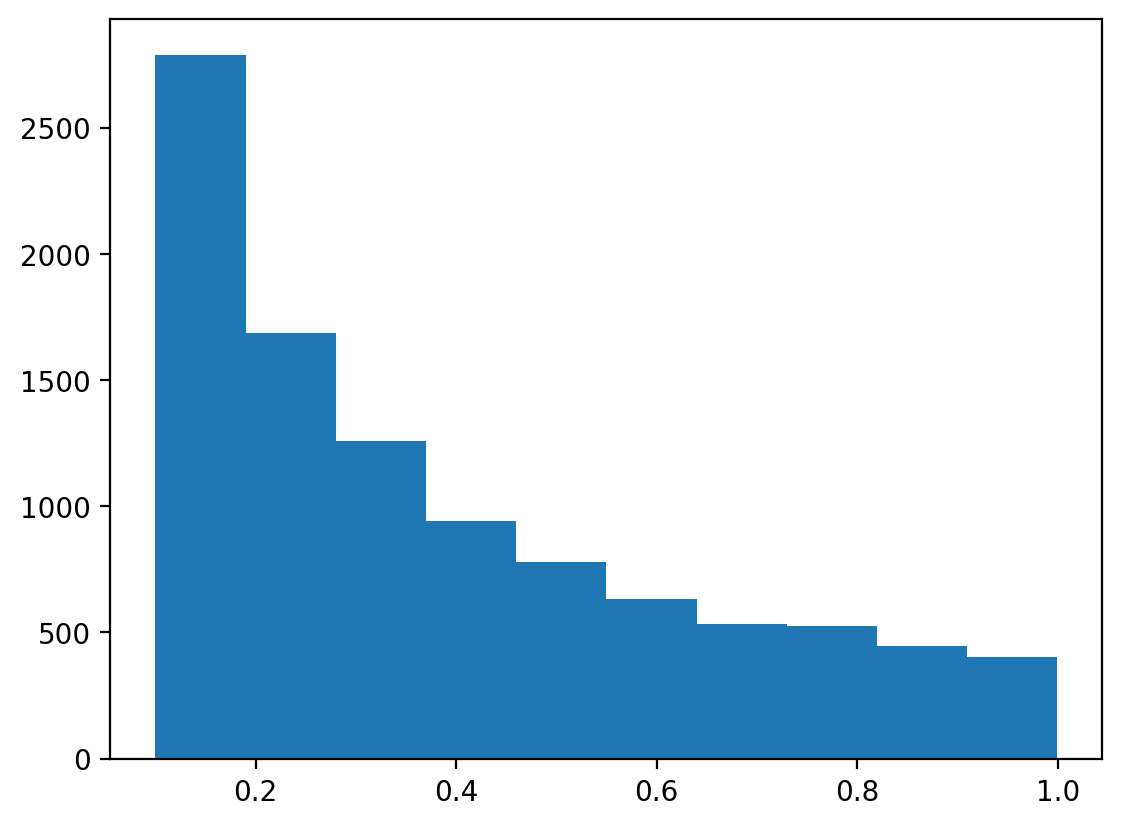

In [26]:
plt.hist(log_uniform.sample(10000))

In [13]:
def log_uniform_dist(x, low = 0.1, high = 1):
    return 1 / (x * np.log(high/low))

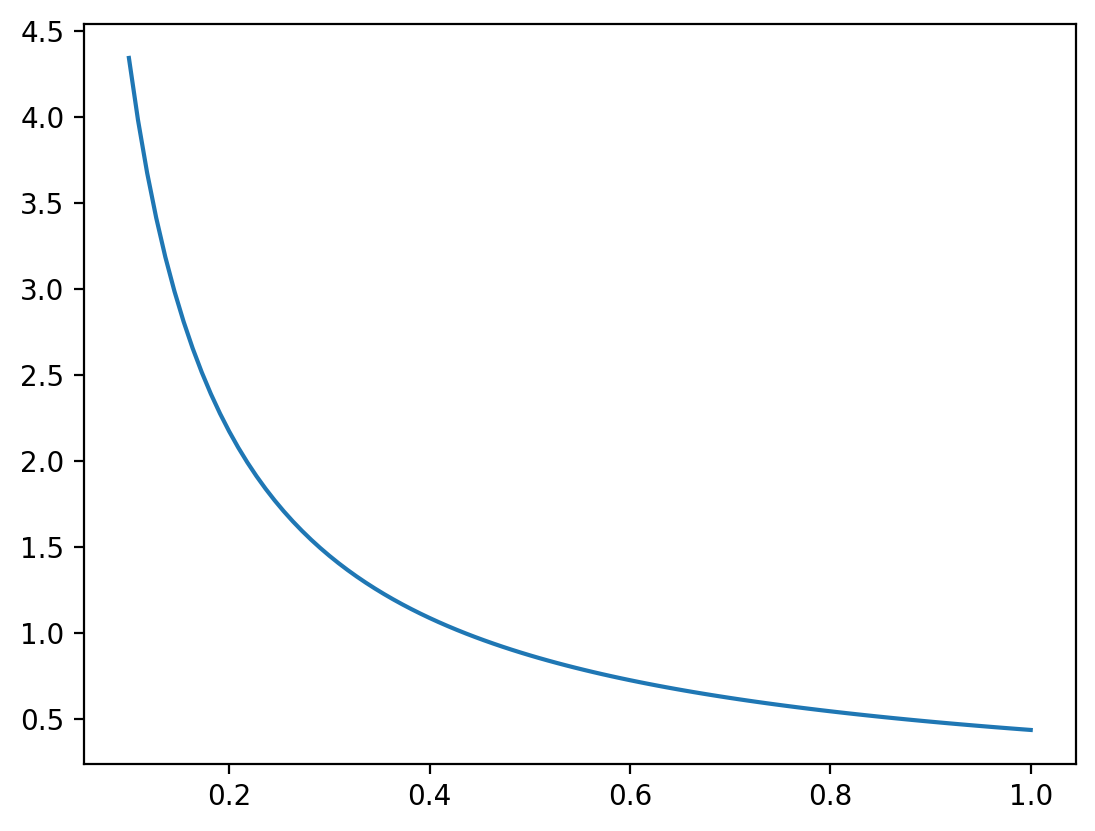

In [15]:
x_plot = np.linspace(0.1, 1, 100)
plt.plot(x_plot, log_uniform_dist(x_plot, low = 0.1, high = 1))

We can use this new distribution as the priors.

In [29]:
# starting with a squared exponential distribution
# with variance 1 and length scale 0.3 as above
se_kernel = gpflow.kernels.SquaredExponential(
    variance = 1,
    lengthscales = 0.3
)

# setting a uniform prior on both
se_kernel.variance.prior = log_uniform
se_kernel.lengthscales.prior = log_uniform

# setting the prior on the likelihood
likelihood = gpflow.likelihoods.Gaussian(
    variance = 0.5**2
)

# set a prior
likelihood.variance.prior = log_uniform

nm_model = gpflow.models.GPR(
    data = (x, y),
    kernel = se_kernel,
    likelihood = likelihood
)

nm_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,expUniform,True,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,expUniform,True,(),float64,0.3
GPR.likelihood.variance,Parameter,Softplus + Shift,expUniform,True,(),float64,0.25


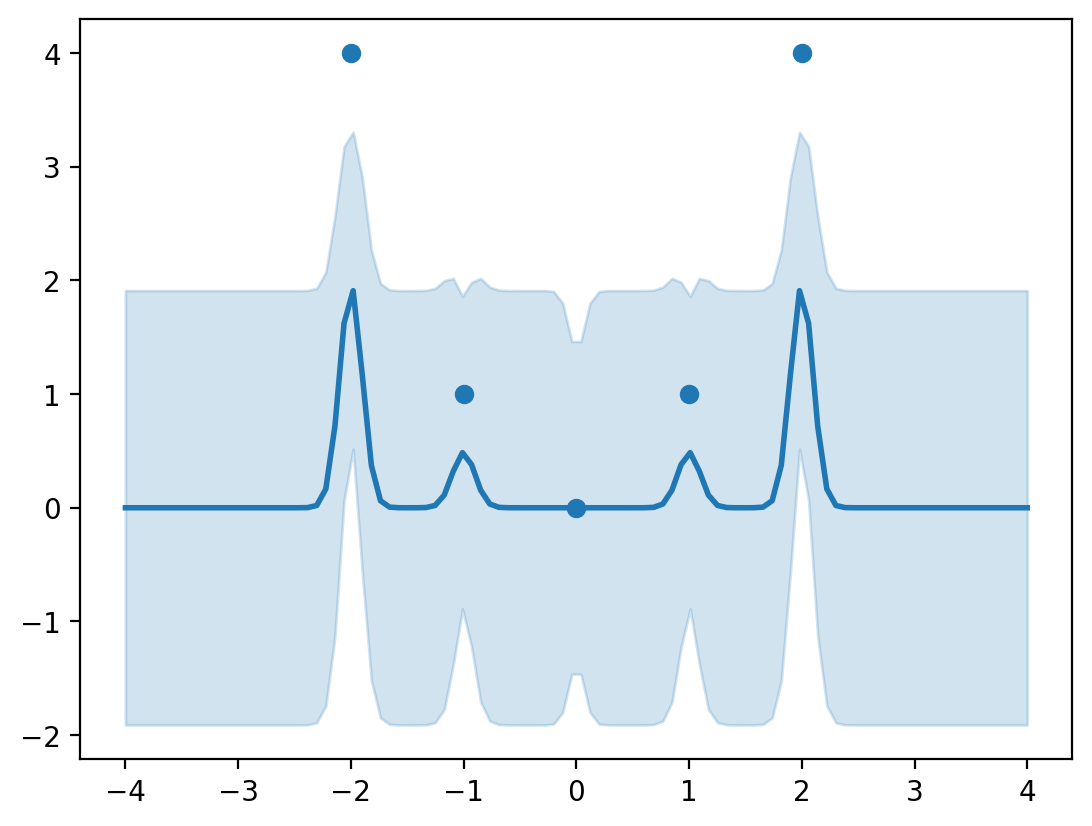

In [30]:
# optimize using Nelder-Mead
opt = gpflow.optimizers.Scipy()
opt.minimize(
    nm_model.training_loss,
    nm_model.trainable_variables,
    method = 'Nelder-Mead'
)

xx = np.linspace(-4, 4, 100).reshape(100,1)
mean, var = nm_model.predict_f(xx)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(xx, mean, lw = 2)
ax.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color = 'C0',
    alpha = 0.2
)

In [31]:
nm_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,expUniform,True,(),float64,0.950008
GPR.kernel.lengthscales,Parameter,Softplus,expUniform,True,(),float64,0.100009
GPR.likelihood.variance,Parameter,Softplus + Shift,expUniform,True,(),float64,0.999986


Most of the shape of the above is driven by the length scale parameter.

### A different optimizer

Using all the same initial parameter values, but selecting a different optimizer, we can assess how this affects the model fit.

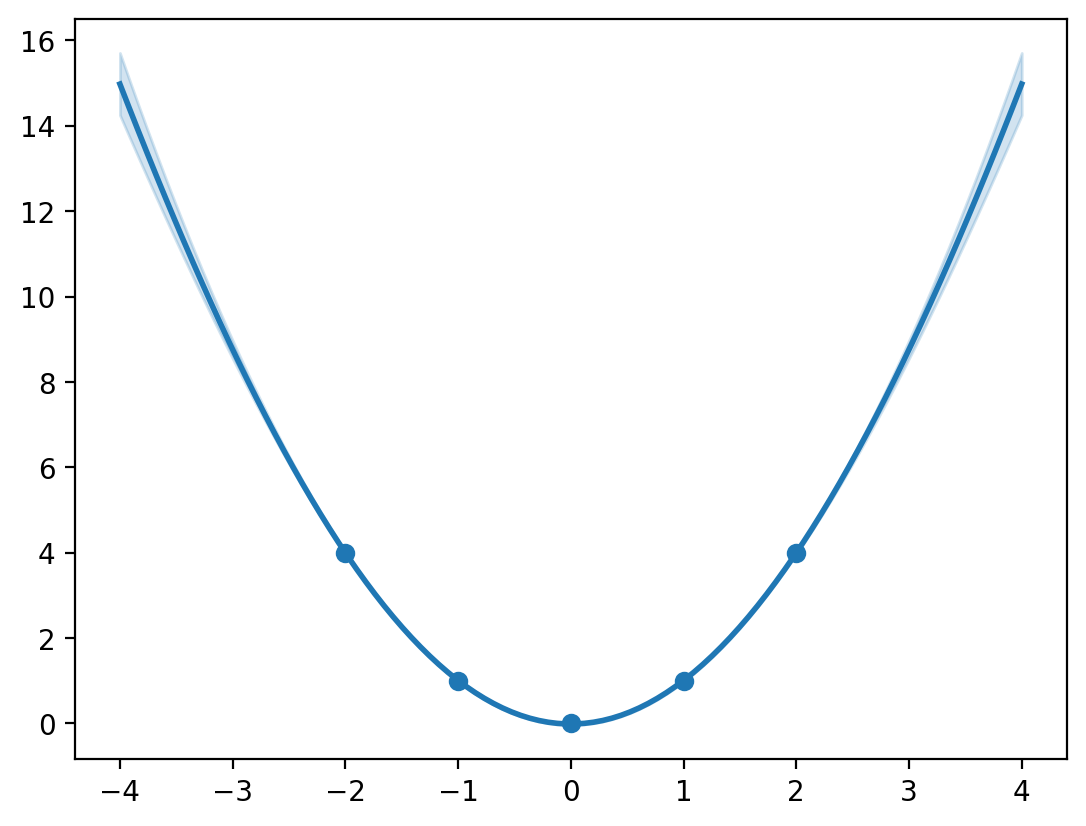

In [32]:
# starting with a squared exponential distribution
# with variance 1 and length scale 0.3 as above
se_kernel = gpflow.kernels.SquaredExponential(
    variance = 1,
    lengthscales = 0.3
)

# setting the prior on the likelihood
likelihood = gpflow.likelihoods.Gaussian(
    variance = 0.5**2
)

nm_model = gpflow.models.GPR(
    data = (x, y),
    kernel = se_kernel,
    likelihood = likelihood
)

# optimize using Nelder-Mead
opt = gpflow.optimizers.Scipy()
opt.minimize(
    nm_model.training_loss,
    nm_model.trainable_variables,
    method = 'CG'
)

xx = np.linspace(-4, 4, 100).reshape(100,1)
mean, var = nm_model.predict_f(xx)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(xx, mean, lw = 2)
ax.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color = 'C0',
    alpha = 0.2
)

In [33]:
nm_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3363.38
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,8.95749
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.000287354


Though this model fits the points very well, it could be argued that this is not the optimal solution because the model predits high precision far away from the points given. Prior distributions on the parameters could solve this "issue" by regularizing the parameters.